For infant cry detection, can use various machine learning models to train the classifier. 

1. **Random Forest Classifier:** Random Forest is an ensemble learning method that can work well for classification tasks. It can handle both numerical and categorical features and is robust against overfitting.

2. **Support Vector Machine (SVM):** SVM is a powerful classifier that can be effective in binary classification tasks like cry detection. It tries to find the hyperplane that best separates the two classes.

3. **Logistic Regression:** Logistic regression is a simple yet effective model for binary classification. It's easy to interpret and can serve as a baseline model.

4. **K-Nearest Neighbors (K-NN):** K-NN is a non-parametric algorithm that classifies an instance based on the majority class among its k-nearest neighbors. It's easy to understand and can work well with appropriate distance metrics.

5. **Gradient Boosting (e.g., XGBoost, LightGBM):** Gradient boosting algorithms can provide high accuracy and can handle complex relationships in the data. They are particularly useful when dealing with imbalanced datasets.

6. **Neural Networks:** Deep learning models, such as convolutional neural networks (CNNs) or recurrent neural networks (RNNs), can be employed for audio-based classification tasks like cry detection. They require a larger amount of data and computational resources but can achieve state-of-the-art performance.

7. **Naive Bayes:** Naive Bayes classifiers are simple probabilistic models that can be suitable for text-based cry detection when text features are used.

8. **Ensemble Methods:** You can create an ensemble of different classifiers to improve overall performance. For example, you can combine the predictions of multiple models like Random Forest, SVM, and Logistic Regression.

9. **Hidden Markov Models (HMMs):** HMMs are commonly used for time-series data and speech recognition. They can be adapted for audio-based cry detection.

The choice of model depends on the complexity of  dataset, the quality of  features, and computational resources. Additionally, consider using techniques like feature engineering, hyperparameter tuning, and cross-validation to optimize model's performance.


In [2]:
from scipy.io.wavfile import read
import scipy.signal as signal
import matplotlib as mpl
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import numpy as np

cmap = mpl.colormaps['Reds']


In [3]:

sampling_rate,data= read(r"D:\infant cry detecting\dev\baby_cry\baby_cry_detection\data\301 - Crying baby\margot.m4a_11.wav")

In [4]:
print(data.shape)

(220500,)


In [5]:
wav=data[:,]

In [6]:
print(type(wav))

<class 'numpy.ndarray'>


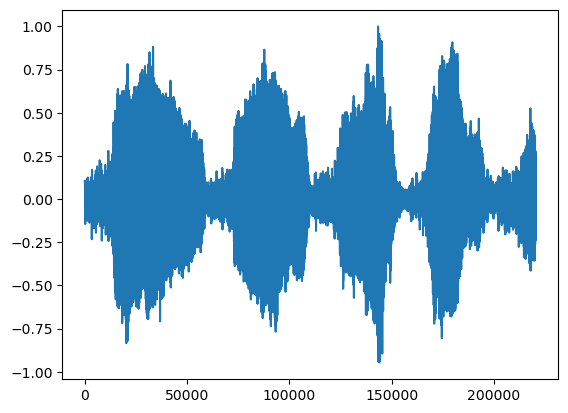

In [7]:
plt.plot(wav)
plt.show()

In [8]:
f, t, Zxx = signal.stft(wav, fs=sampling_rate)

In [9]:
print(f.shape)

(129,)


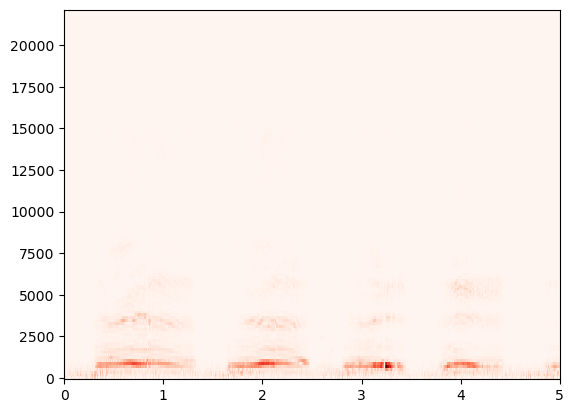

In [10]:
plt.pcolormesh(t, f, np.abs(Zxx), cmap=cmap)

In [118]:
import os
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import skew, kurtosis
from sklearn.experimental import enable_hist_gradient_boosting  # Enable the experimental module
from sklearn.ensemble import HistGradientBoostingClassifier


In [119]:
# Directory containing the infant cry audio files
data_dir_cry = r"D:\infant cry detecting\dev\baby_cry\baby_cry_detection\data\301 - Crying baby"

# List all files in the directory
audio_files_cry = os.listdir(data_dir_cry)

In [120]:
# Directory containing the infant non-cry audio files
data_dir_non_cry = r"D:\infant cry detecting\dev\baby_cry\baby_cry_detection\data\901 - Silence"

# List all files in the directory
audio_files_non_cry = os.listdir(data_dir_non_cry)

In [121]:
# Sample rate and other parameters
fs = 500  # Sample rate 
nperseg = 64  # Window size for STFT 
noverlap = 8  # Overlap between windows 

# Initialize empty lists for features
features = []
labels = []


In [122]:
# Function to extract features from an audio file
def extract_features(audio_path, is_cry):
    # Read the audio file
    fs, audio_signal = wavfile.read(audio_path)

    # Compute STFT
    f, t, Sxx = spectrogram(audio_signal, fs=fs, nperseg=nperseg, noverlap=noverlap)

    # Calculate the 20 features from STFT
    tf_mean = np.mean(Sxx)
    tf_std = np.std(Sxx)
    
    tma = np.max(Sxx, axis=0)
    tma_max = np.max(tma)
    tma_min = np.min(tma)
    tma_mean = np.mean(tma)
    tma_std = np.std(tma)
    tma_skewness = skew(tma)
    tma_kurt = kurtosis(tma)
        
    fma = np.max(Sxx, axis=1)
    fma_max = np.max(fma)
    fma_min = np.min(fma)
    fma_mean = np.mean(fma)
    fma_std = np.std(fma)
    fma_skewness = skew(fma)
    fma_kurt = kurtosis(fma)
        
    fsda = np.std(Sxx, axis=1)
    fsda_max = np.max(fsda)
    fsda_min = np.min(fsda)
    fsda_mean = np.mean(fsda)
    fsda_std = np.std(fsda)
    fsda_skewness = skew(fsda)
    fsda_kurt = kurtosis(fsda)

    # Combine features into a feature vector
    feature_vector = np.array([ tf_mean, tf_std,
                               tma_max, tma_min, tma_mean, tma_std, tma_skewness, tma_kurt,
                               fma_max, fma_min, fma_mean, fma_std, fma_skewness, fma_kurt, 
                               fsda_max, fsda_min, fsda_mean, fsda_std, fsda_skewness, fsda_kurt])

    return feature_vector


In [123]:
# Loop through each cry audio file
for audio_file in os.listdir(data_dir_cry):
    if audio_file.endswith(".wav"):
        audio_path = os.path.join(data_dir_cry, audio_file)
        feature_vector = extract_features(audio_path, is_cry=1)
        features.append(feature_vector)

In [124]:
# Loop through each non-cry audio file
for audio_file in os.listdir(data_dir_non_cry):
    if audio_file.endswith(".wav"):
        audio_path = os.path.join(data_dir_non_cry, audio_file)
        feature_vector = extract_features(audio_path, is_cry=0)
        features.append(feature_vector)

In [125]:
# Create a DataFrame with the extracted features
column_names = ['IsCry', 'TF_Mean', 'TF_Std', 'TMA_Max', 'TMA_Min', 'TMA_Mean', 'TMA_Std', 'TMA_Skewness', 'TMA_Kurtosis',
                'FMA_Max', 'FMA_Min', 'FMA_Mean', 'FMA_Std', 'FMA_Skewness', 'FMA_Kurtosis',
                'FSDA_Max', 'FSDA_Min', 'FSDA_Mean', 'FSDA_Std', 'FSDA_Skewness', 'FSDA_Kurtosis']


In [126]:
df = pd.DataFrame(features, columns=column_names)

# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

ValueError: 21 columns passed, passed data had 20 columns

In [85]:
# Split the data into features (X) and labels (y)
X = df.drop('IsCry', axis=1)
y = df['IsCry']

In [86]:
# Handle missing values in X using SimpleImputer (replace NaNs with the mean of each feature)
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)


In [87]:
# Drop rows with missing values
df.dropna(inplace=True)

In [88]:
# Convert the target variable to integers (0 for non-cry, 1 for cry)
y = y.astype(int)


In [90]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [91]:
# Initialize and train a Random Forest Classifier
#clf = RandomForestClassifier(n_estimators=100, random_state=42)
#clf.fit(X_train, y_train)
clf = HistGradientBoostingClassifier(random_state=42)
clf.fit(X_train, y_train)


HistGradientBoostingClassifier(random_state=42)

In [93]:
# Make predictions on the test set
y_pred = clf.predict(X_test)


In [94]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)


In [95]:
print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        13

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



In [106]:
# Example: Classify a new audio clip
new_audio_path = r"D:\infant cry detecting\dev\baby_cry\baby_cry_detection\data\301 - Crying baby\V_2017-04-01+08_06_22=0_30.mp3_12.wav"

new_feature_vector = extract_features(new_audio_path,  is_cry = None)
prediction = clf.predict([new_feature_vector])

if prediction[0] == 1:
    print("The new audio clip contains a cry sound.")
else:
    print("The new audio clip does not contain a cry sound.")

The new audio clip contains a cry sound.


In [107]:
# Folder containing the audio clips you want to classify
folder_path = r"D:\infant cry detecting\dev\baby_cry\baby_cry_detection\data\New folder"

# List all audio files in the folder
audio_files = [f for f in os.listdir(folder_path) if f.endswith(".wav")]

# Classify each audio clip in the folder
for audio_file in audio_files:
    # Get the full path to the audio file
    audio_path = os.path.join(folder_path, audio_file)

    # Extract features from the audio clip
    new_feature_vector = extract_features(audio_path, is_cry = None)

    # Make a prediction using the trained model
    prediction = clf.predict([new_feature_vector])

    # Interpret the prediction
    if prediction[0] == 1:
        print(f" '{audio_file}' - a cry sound.")
    else:
        print(f"'{audio_file}' - not a cry sound.")

'Louise_01.m4a_0.wav' - not a cry sound.
 'Louise_01.m4a_1.wav' - a cry sound.
 'Louise_01.m4a_10.wav' - a cry sound.
 'Louise_01.m4a_11.wav' - a cry sound.
 'Louise_01.m4a_12.wav' - a cry sound.
 'Louise_01.m4a_13.wav' - a cry sound.
 'Louise_01.m4a_14.wav' - a cry sound.
 'Louise_01.m4a_2.wav' - a cry sound.
 'Louise_01.m4a_3.wav' - a cry sound.
 'Louise_01.m4a_4.wav' - a cry sound.
 'Louise_01.m4a_5.wav' - a cry sound.
 'Louise_01.m4a_6.wav' - a cry sound.
 'Louise_01.m4a_7.wav' - a cry sound.
 'Louise_01.m4a_8.wav' - a cry sound.
 'Louise_01.m4a_9.wav' - a cry sound.
 'margot.m4a_0.wav' - a cry sound.
 'margot.m4a_1.wav' - a cry sound.
 'margot.m4a_10.wav' - a cry sound.
'margot.m4a_11.wav' - not a cry sound.
 'margot.m4a_12.wav' - a cry sound.
 'margot.m4a_13.wav' - a cry sound.
 'margot.m4a_14.wav' - a cry sound.
 'margot.m4a_15.wav' - a cry sound.
 'margot.m4a_16.wav' - a cry sound.
 'margot.m4a_17.wav' - a cry sound.
 'margot.m4a_18.wav' - a cry sound.
 'margot.m4a_19.wav' - a 

In [127]:
from sklearn.model_selection import GridSearchCV

In [128]:
sklearn.metrics.confusion_matrix(y_test, y_pred)

array([[22,  1],
       [ 1, 12]], dtype=int64)

Train a Support Vector Machine (SVM) Classifier

In [130]:
from sklearn.impute import SimpleImputer  # Import SimpleImputer for handling missing values
from sklearn.svm import SVC


In [131]:
# Initialize and train a Support Vector Machine (SVM) Classifier
clf = SVC(kernel='linear', C=1.0, random_state=42)

# Convert the target variable to integers (0 for non-cry, 1 for cry)
y = y.astype(int)

clf.fit(X_train, y_train)


SVC(kernel='linear', random_state=42)

In [132]:
# Now, you can use X_test_df for prediction
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)



Accuracy: 0.9444444444444444
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96        23
           1       0.92      0.92      0.92        13

    accuracy                           0.94        36
   macro avg       0.94      0.94      0.94        36
weighted avg       0.94      0.94      0.94        36



Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression

In [133]:
# Make predictions on the test set
y_pred = clf.predict(X)

# Evaluate the model (this is for training evaluation; you should split your data for proper evaluation)
accuracy = accuracy_score(y, y_pred)
report = classification_report(y, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)



Accuracy: 0.9090909090909091
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.93       108
           1       0.92      0.84      0.88        68

    accuracy                           0.91       176
   macro avg       0.91      0.90      0.90       176
weighted avg       0.91      0.91      0.91       176



In [134]:
# Now, for testing a new audio clip:
new_audio_path = r"D:\infant cry detecting\dev\baby_cry\baby_cry_detection\data\301 - Crying baby\V_2017-04-01+08_06_22=0_30.mp3_12.wav"

new_feature_vector = extract_features(new_audio_path,  is_cry = None)
prediction = clf.predict([new_feature_vector])

if prediction[0] == 1:
    print("The new audio clip contains a cry sound.")
else:
    print("The new audio clip does not contain a cry sound.")

The new audio clip contains a cry sound.


K-Nearest Neighbors (K-NN)

In [137]:
from sklearn.neighbors import KNeighborsClassifier 

In [135]:
# Ensure X is in a suitable format (NumPy array)
X = np.array(X)

# Check if X is C-contiguous
if not X.flags.c_contiguous:
    # If not C-contiguous, create a new C-contiguous array and copy the data
    X = np.ascontiguousarray(X)

In [136]:
# Initialize and train a K-Nearest Neighbors (K-NN) Classifier
clf = KNeighborsClassifier(n_neighbors=3)  # can adjust the number of neighbors as needed
clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [138]:
# Make predictions on the test set
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.8611111111111112
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.91      0.89        23
           1       0.83      0.77      0.80        13

    accuracy                           0.86        36
   macro avg       0.85      0.84      0.85        36
weighted avg       0.86      0.86      0.86        36



In [139]:
# Now, for testing a new audio clip:
new_audio_path = r"D:\infant cry detecting\dev\baby_cry\baby_cry_detection\data\301 - Crying baby\V_2017-04-01+08_06_22=0_30.mp3_12.wav"

new_feature_vector = extract_features(new_audio_path,  is_cry = None)
prediction = clf.predict([new_feature_vector])

if prediction[0] == 1:
    print("The new audio clip contains a cry sound.")
else:
    print("The new audio clip does not contain a cry sound.")

The new audio clip contains a cry sound.


Gradient Boosting (e.g., XGBoost)

In [71]:
import xgboost as xgb

In [140]:
# Initialize and train an XGBoost Classifier
clf = xgb.XGBClassifier(random_state=42)
clf.fit(X_train, y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [141]:
# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.9166666666666666
Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.94        23
           1       1.00      0.77      0.87        13

    accuracy                           0.92        36
   macro avg       0.94      0.88      0.90        36
weighted avg       0.93      0.92      0.91        36



In [142]:
# Now, for testing a new audio clip:
new_audio_path = r"D:\infant cry detecting\dev\baby_cry\baby_cry_detection\data\301 - Crying baby\V_2017-04-01+08_06_22=0_30.mp3_12.wav"

new_feature_vector = extract_features(new_audio_path,  is_cry = None)
prediction = clf.predict([new_feature_vector])

if prediction[0] == 1:
    print("The new audio clip contains a cry sound.")
else:
    print("The new audio clip does not contain a cry sound.")


The new audio clip contains a cry sound.


Neural Networks

In [143]:
import tensorflow as tf
from tensorflow import keras

In [152]:

# Build a neural network model
model = keras.Sequential([
    keras.layers.Input(20),  # Input layer with the number of features
    keras.layers.Dense(64, activation='relu'),  # Hidden layer with 64 units and ReLU activation
    keras.layers.Dense(32, activation='relu'),  # Hidden layer with 32 units and ReLU activation
    keras.layers.Dense(1, activation='sigmoid')  # Output layer with 1 unit and sigmoid activation
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)




Epoch 1/10
4/4 [==============================] - 1s 47ms/step - loss: 7.0902 - accuracy: 0.5089 - val_loss: 2.3476 - val_accuracy: 0.5000
Epoch 2/10
4/4 [==============================] - 0s 12ms/step - loss: 2.7251 - accuracy: 0.5089 - val_loss: 0.7571 - val_accuracy: 0.6071
Epoch 3/10
4/4 [==============================] - 0s 12ms/step - loss: 0.9040 - accuracy: 0.6071 - val_loss: 0.7650 - val_accuracy: 0.6071
Epoch 4/10
4/4 [==============================] - 0s 12ms/step - loss: 0.8364 - accuracy: 0.6429 - val_loss: 0.7235 - val_accuracy: 0.5000
Epoch 5/10
4/4 [==============================] - 0s 12ms/step - loss: 0.7757 - accuracy: 0.5714 - val_loss: 0.7672 - val_accuracy: 0.5000
Epoch 6/10
4/4 [==============================] - 0s 12ms/step - loss: 0.7615 - accuracy: 0.5536 - val_loss: 0.7178 - val_accuracy: 0.5000
Epoch 7/10
4/4 [==============================] - 0s 11ms/step - loss: 0.6954 - accuracy: 0.5714 - val_loss: 0.5814 - val_accuracy: 0.5000
Epoch 8/10
4/4 [===========

In [153]:
# Evaluate the model on the test set
accuracy = model.evaluate(X_test, y_test)[1]
print("Test Accuracy:", accuracy)


2/2 [==============================] - 0s 6ms/step - loss: 0.5808 - accuracy: 0.6389
Test Accuracy: 0.6388888955116272


In [154]:
# Now, for testing a new audio clip:
new_audio_path = r"D:\infant cry detecting\dev\baby_cry\baby_cry_detection\data\301 - Crying baby\V_2017-04-01+08_06_22=0_30.mp3_12.wav"

new_feature_vector = extract_features(new_audio_path,  is_cry = None)
prediction = clf.predict([new_feature_vector])

if prediction[0] == 1:
    print("The new audio clip contains a cry sound.")
else:
    print("The new audio clip does not contain a cry sound.")

The new audio clip contains a cry sound.
